In [4]:
import os
import sys
import cv2
import numpy as np
import glob
import json

def println(value):
    print(value, end="")
    print('\r', end="")


class Equirectangular:
    def __init__(self, img_name):
        self._img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
    

    def GetPerspective(self, FOV, THETA, PHI, height, width):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0

        wFOV = FOV
        hFOV = float(height) / width * wFOV

        w_len = np.tan(np.radians(wFOV / 2.0))
        h_len = np.tan(np.radians(hFOV / 2.0))


        x_map = np.ones([height, width], np.float32)
        y_map = np.tile(np.linspace(-w_len, w_len,width), [height,1])
        z_map = -np.tile(np.linspace(-h_len, h_len,height), [width,1]).T

        D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
        xyz = np.stack((x_map,y_map,z_map),axis=2)/np.repeat(D[:, :, np.newaxis], 3, axis=2)
        
        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        z_axis = np.array([0.0, 0.0, 1.0], np.float32)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2])
        lon = np.arctan2(xyz[:, 1] , xyz[:, 0])

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180

        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90  * equ_cy + equ_cy

        
            
        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
        return persp

In [29]:
def panorama2cube(label_input_dir, label_output_dir, target_input_dir, target_output_dir, label_to_target_map):

    rect_height = 1920
    rect_width  = 1440

    label_filenames = [filename for filename in os.listdir(label_input_dir) if '.png' in filename]
    total = len(label_filenames)
    
    println(f'Progress: 0/{total}')

    for i, label_filename in enumerate(label_filenames):
        
        target_filename = label_to_target_map[label_filename]
        label_path = f'{label_input_dir}/{label_filename}'
        target_path = f'{target_input_dir}/{target_filename}'
        equ_label = Equirectangular(label_path)    # Load equirectangular image
        equ_target = Equirectangular(target_path)
    
        #
        # FOV unit is degree
        # theta is z-axis angle(right direction is positive, left direction is negative)
        # phi is y-axis angle(up direction positive, down direction negative)
        # height and width is output image dimension
        #

        out_path_label = f'{label_output_dir}/{target_filename.replace(".JPG", "_")}'
        out_path_target = f'{target_output_dir}/{target_filename.replace(".JPG", "_")}'
        
        img_label = equ_label.GetPerspective(90, 0, 0, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output1 = out_path_label +  'front.png'
        cv2.imwrite(output1, img_label)
        img_target = equ_target.GetPerspective(90, 0, 0, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output1_target = out_path_target +  'front.png'
        cv2.imwrite(output1_target, img_target)
        
        img_label = equ_label.GetPerspective(90, 90, 0, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output2 = out_path_label + 'right.png' 
        cv2.imwrite(output2, img_label)
        img_target = equ_target.GetPerspective(90, 90, 0, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output2_target = out_path_target + 'right.png' 
        cv2.imwrite(output2_target, img_target)


        img_label = equ_label.GetPerspective(90, 180, 0, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output3 = out_path_label + 'back.png' 
        cv2.imwrite(output3, img_label)
        img_target = equ_target.GetPerspective(90, 180, 0, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output3_target = out_path_target + 'back.png' 
        cv2.imwrite(output3_target, img_target)

        img_label = equ_label.GetPerspective(90, 270, 0, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output4 = out_path_label + 'left.png' 
        cv2.imwrite(output4, img_label)
        img_target = equ_target.GetPerspective(90, 270, 0, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output4_target = out_path_target + 'left.png' 
        cv2.imwrite(output4_target, img_target)

        img_label = equ_label.GetPerspective(90, 0, 90, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output5 = out_path_label + 'top.png' 
        cv2.imwrite(output5, img_label)
        img_target = equ_target.GetPerspective(90, 0, 90, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output5_target = out_path_target + 'top.png' 
        cv2.imwrite(output5_target, img_target)

        img_label = equ_label.GetPerspective(90, 0, -90, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output6 = out_path_label + 'bottom.png' 
        cv2.imwrite(output6, img_label)
        img_target = equ_target.GetPerspective(90, 0, -90, rect_height, rect_width)  # Specify parameters(FOV, theta, phi, height, width)
        output6_target = out_path_target + 'bottom.png' 
        cv2.imwrite(output6_target, img_target)
                       
        println(f'Progress: {i + 1}/{total}')
    println('\n')
    println('Done!')

In [13]:
5760 / 3

1920.0

In [14]:
2880 / 2

1440.0

In [18]:
for i in range(300, 600):
    if 1920 % i == 0 and 1440 % i == 0:
        print(i, 1920 / i, 1440 / i)

480 4.0 3.0


In [26]:
labels_to_targets = []
with open('./labels-to-targets-map.json') as lttmjson:
    labels_to_targets = json.load(lttmjson)
labels_to_targets = {label: values["image"] for label, values in labels_to_targets.items()}

In [23]:
fakelttmap = {
    '20210914-kruununhaka_GSAD0171label.png': '20210914-kruununhaka_GSAD0170.JPG', 
    '20210914-kruununhaka_GSAD0221label.png': '20210914-kruununhaka_GSAD0220.JPG', 
}
panorama2cube('./perspective-correction-test/input_labels', './perspective-correction-test/output_labels', './perspective-correction-test/input_targets', './perspective-correction-test/output_targets', fakelttmap)

Progress: 2/2


In [30]:
panorama2cube('./labels/2021-12-18/SegmentationClass', './labels/perspective_corrected/SegmentationClass', './data_360/images', './data_perspective_corrected/images', labels_to_targets)

Premature end of JPEG file


Premature end of JPEG file


Progress: 1029/1029


# Check a few images to make sure everything looks OK

In [62]:
import re
import random
import matplotlib.pyplot as plt
from PIL import Image

In [53]:
list(labels_to_targets.items())[:5]

[('20210914-kruununhaka_GSAD0170.png', '20210914-kruununhaka_GSAD0170.JPG'),
 ('20210914-kruununhaka_GSAD0171.png', '20210914-kruununhaka_GSAD0171.JPG'),
 ('20210914-kruununhaka_GSAD0172.png', '20210914-kruununhaka_GSAD0172.JPG'),
 ('20210914-kruununhaka_GSAD0173.png', '20210914-kruununhaka_GSAD0173.JPG'),
 ('20210914-kruununhaka_GSAD0174.png', '20210914-kruununhaka_GSAD0175.JPG')]

In [48]:
splitter = r'_(back|front|bottom|top|left|right)'
re.split(splitter, '20210914-kruununhaka_GSAE0581_bottom.png')

['20210914-kruununhaka_GSAE0581', 'bottom', '.png']

In [55]:
def pc_label_to_target(labels_to_targets, label):
    splitter = r'_(back|front|bottom|top|left|right)'
    [label, position, suffix] = re.split(splitter, label)
    key = label+suffix
    target = labels_to_targets[key].replace('.JPG', f'_{position}{suffix}')
    return target

labels = os.listdir('./labels/perspective_corrected/SegmentationClass/')
pc_label_to_target(labels_to_targets, labels[0])

'20210914-kruununhaka_GSAI1020_top.png'

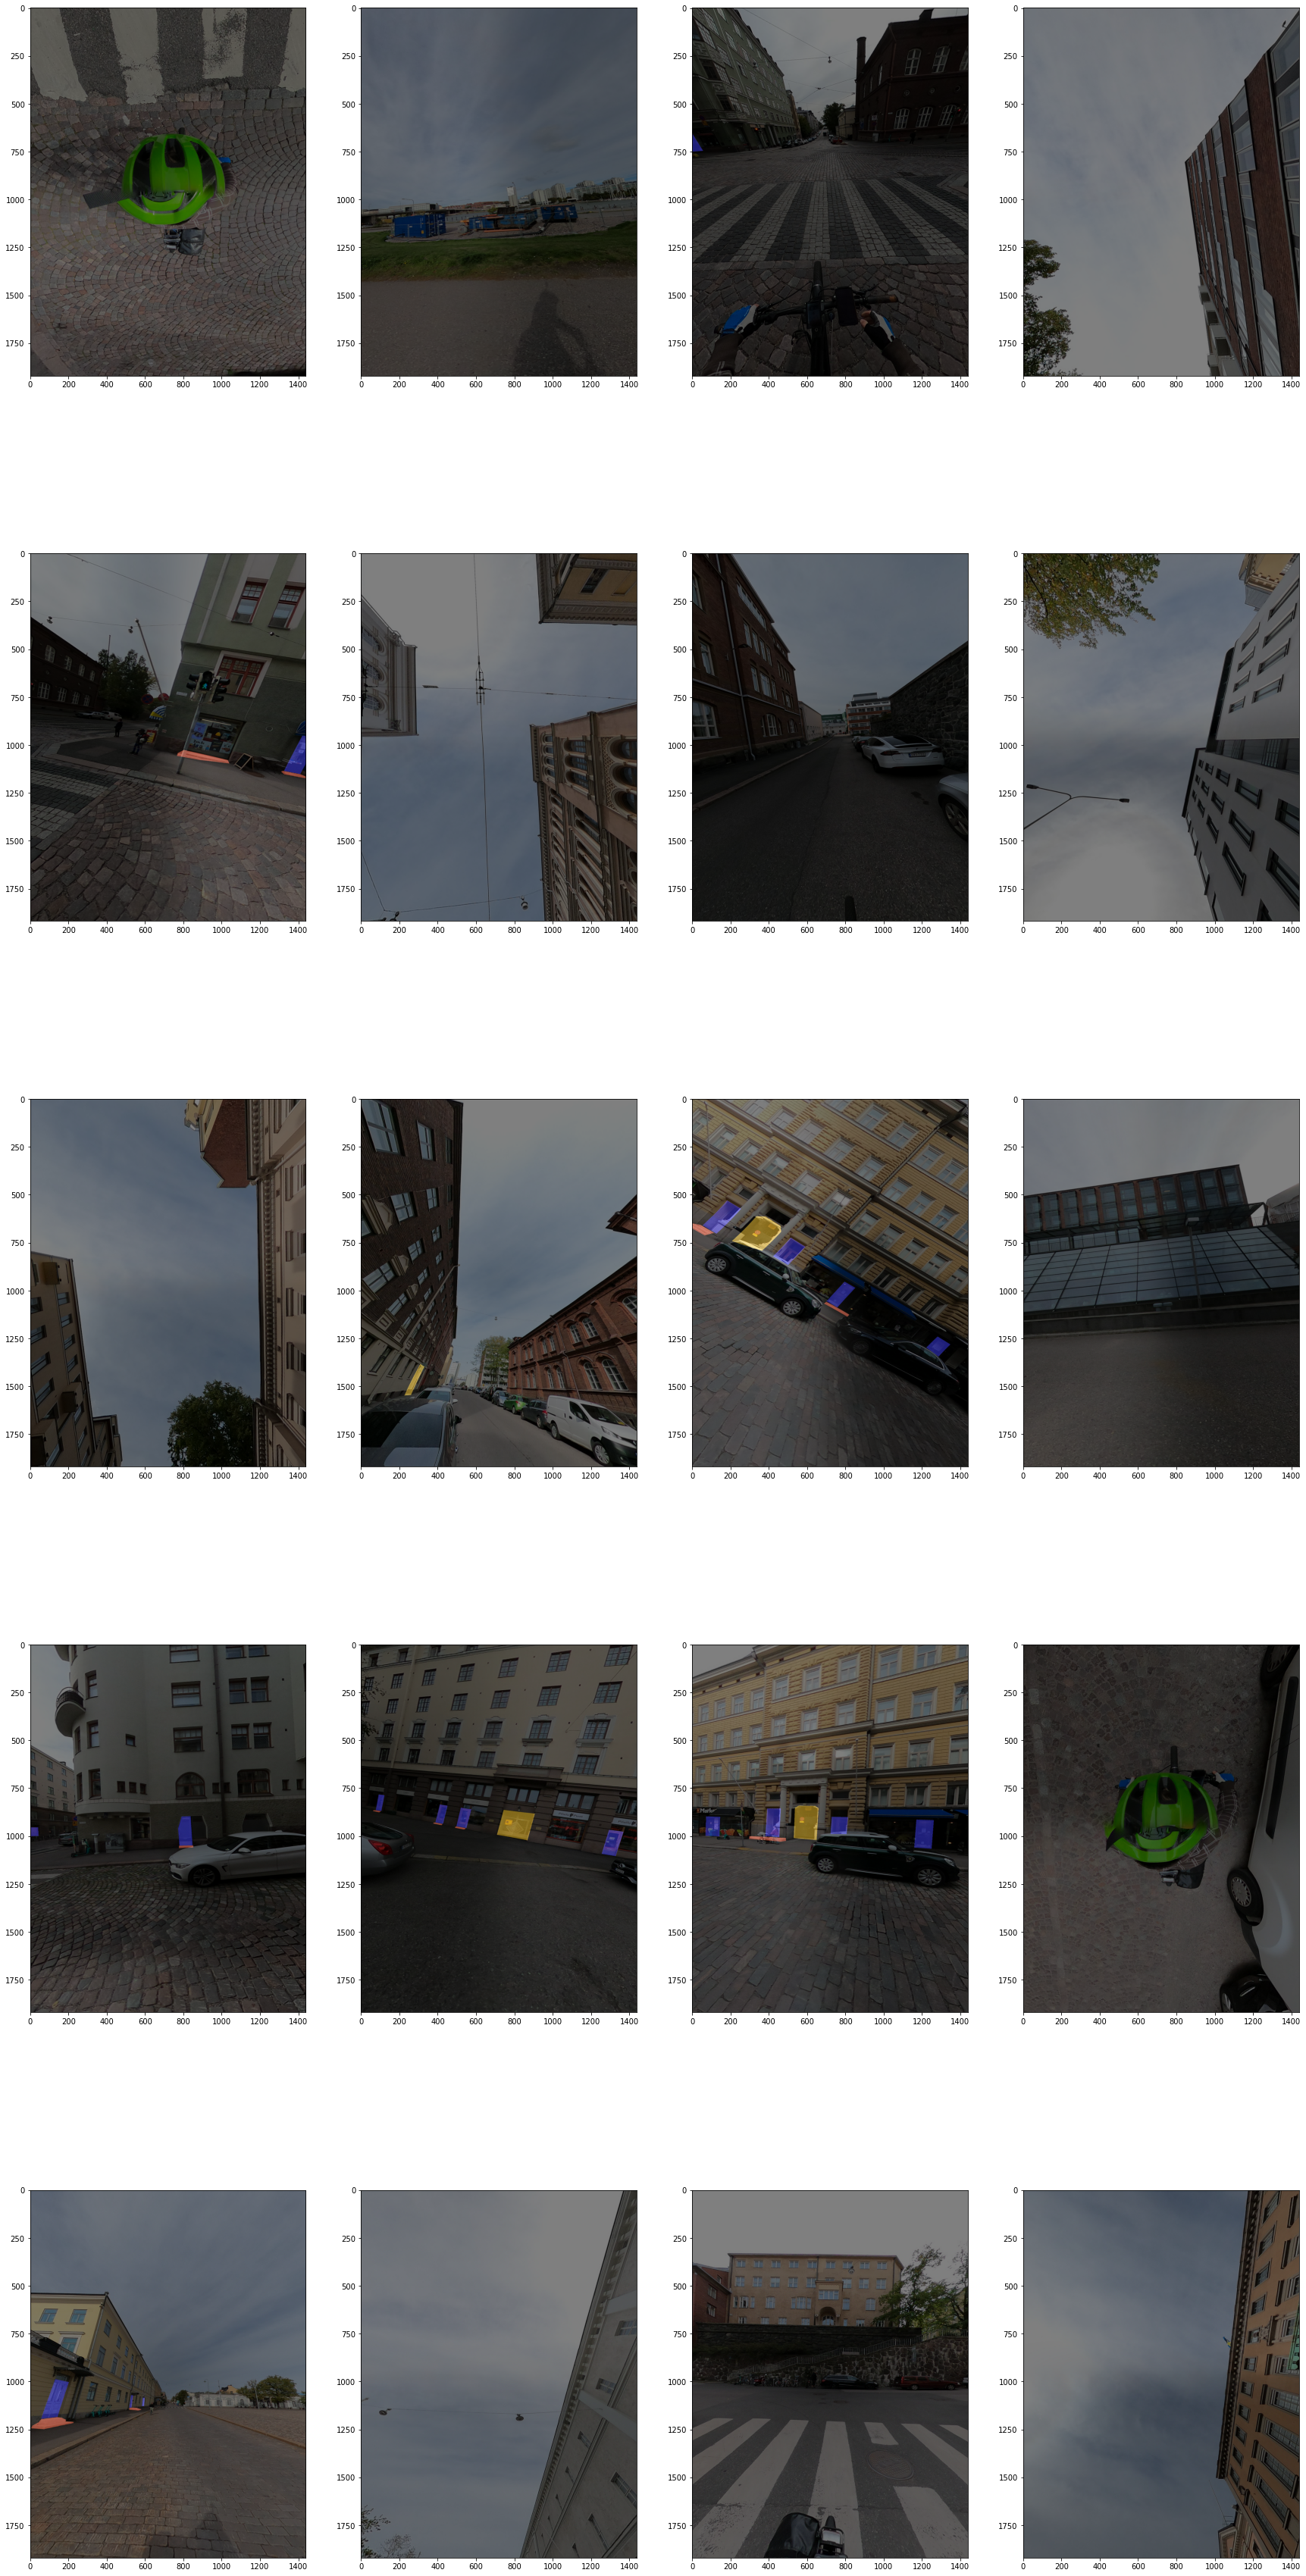

In [78]:
indexes = random.sample(range(0, len(labels)), k=20)
labels = [labels[i] for i in indexes]

fig, axs = plt.subplots(5, 4, figsize=(30, 64))
idx = 0
for i in range(0, 5):
    for j in range(0, 4):
        label = Image.open(f'./labels/perspective_corrected/SegmentationClass/{labels[idx]}')
        target = Image.open(f'./data_perspective_corrected/images/{labels[idx]}')
        img = Image.blend(label, target, 0.5)
        idx+=1
        axs[i][j].imshow(img)